In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [17]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        action_values = Q[observation]
        best_action_value = max(action_values)
        best_action = next(i for i,q in enumerate(action_values) if q==best_action_value)
        # random sample
        prob_other = epsilon / nA
        prob_best = epsilon / nA + (1 - epsilon)
        probs = [prob_other] * nA
        probs[best_action] = prob_best

        select_action = np.random.choice(np.arange(nA), p=probs)
        return select_action

    return policy_fn

In [18]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # 
    for i_episode in range(1, num_episodes+1):
        # log
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # sample one episode in tuples of SAC(state, action, reward)
        episode = []
        observation = env.reset()
        while True:
            action = policy(observation)
            next_observation, reward, done, _ = env.step(action)
            episode.append(tuple([observation, action, reward]))
            observation = next_observation
            if done:
                break
        
        # update state-action value function, Q
        state_action_pairs = set([tuple([x[0], x[1]]) for x in episode])
        for s_a in state_action_pairs:
            s, a = s_a
            first_occurance_index = next(i for i, x in enumerate(episode) if x[0]==s and x[1]==a)
            q_sa = np.sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[first_occurance_index:])])
            returns_sum[s_a] += q_sa
            returns_count[s_a] += 1
            Q[s][a] = returns_sum[s_a] / returns_count[s_a]
            
        # skip: update policy with MC (already did with the defined policy function)
    
    return Q, policy

In [19]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000

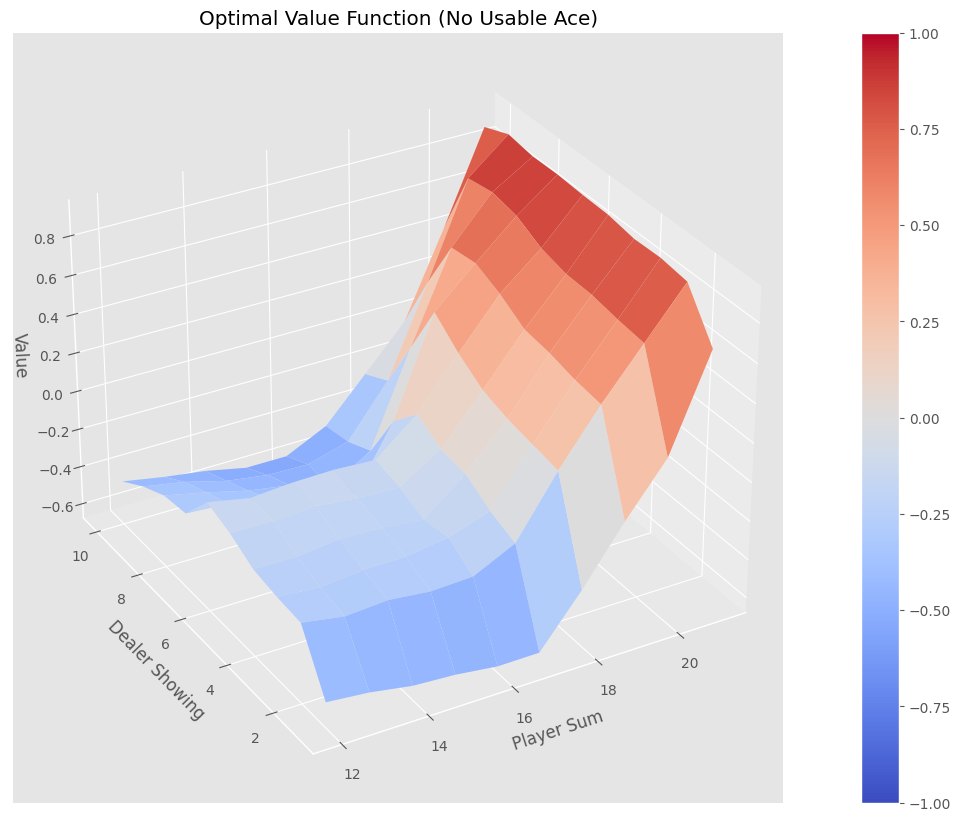

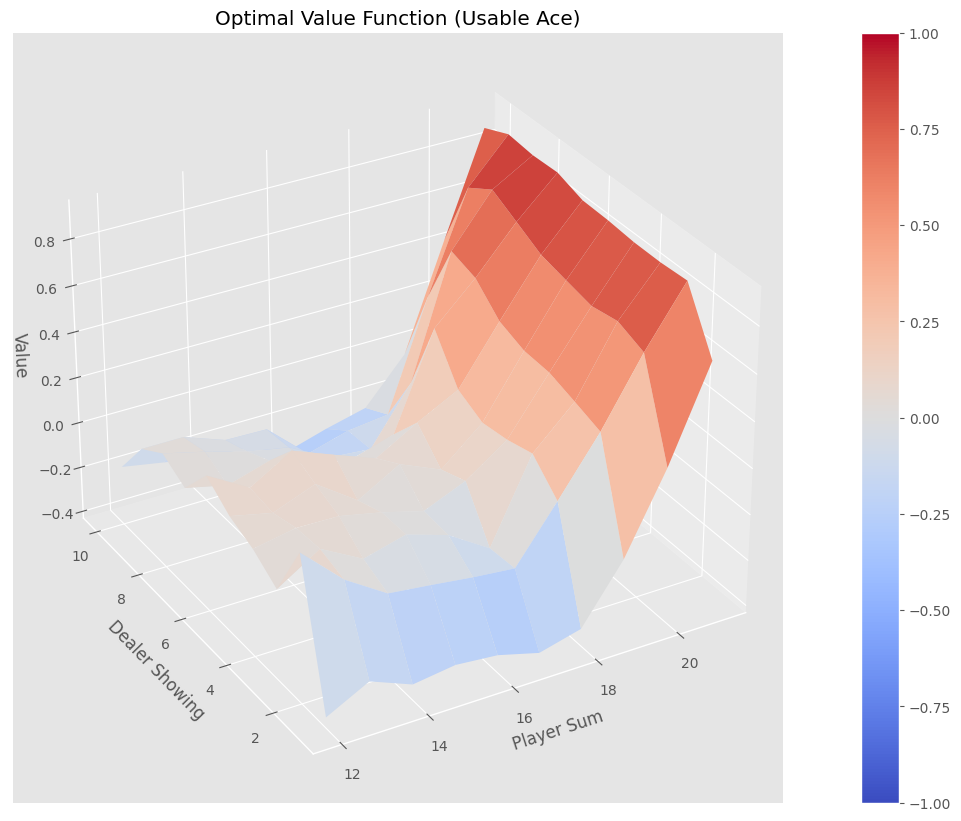

In [20]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")